In [22]:
import sys 
import re
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
# nltk.download('wordnet')

# sys.path.insert(0, '..')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from utils.text_processing import apply_regexes, unescape_html, remove_html_tags, remove_line_breaks, preprocess

In [3]:
df = pd.read_csv('../data/Reviews.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2ce803f98>]],
      dtype=object)

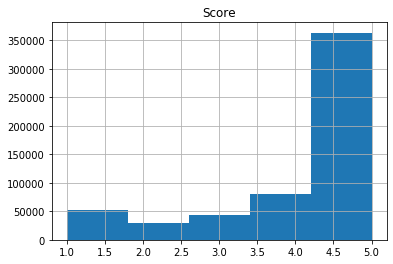

In [4]:
df.hist(column = 'Score', bins=5)

# Data Preprocessing

In [5]:
df['cleaned_text'] = df['Text'] + ' ' + df['Summary']
df['cleaned_text'].fillna("", inplace=True)

df['cleaned_text'] = df['cleaned_text'] \
    .apply(lambda x: unescape_html(remove_html_tags(remove_line_breaks(x), 'html.parser')))

In [9]:
df['cleaned_text'] = df['cleaned_text'].apply(preprocess)

In [11]:
df.loc[df['Score'] <= 3, 'sentiment'] = 0
df.loc[df['Score'] > 3, 'sentiment'] = 1

df['sentiment'] = df['sentiment'].astype(int)

# Comparing Results

## No Sampling: Baseline

In [14]:
x_train, x_test, y_train, y_test = train_test_split(
    df['cleaned_text'], 
    df['sentiment'], 
    test_size=0.2, 
    random_state=1, 
    stratify=df['sentiment']
)

print(f'Number of train samples: {len(x_train)}')
print(f'Number of test samples: {len(x_test)}')

Number of train samples: 454763
Number of test samples: 113691


### With TF-IDF

In [15]:
tfidf_vectorizer = TfidfVectorizer(max_df=100000)
tfidf_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_test = tfidf_vectorizer.transform(x_test)

In [27]:
lr_tfidf = LogisticRegression(penalty='l2', random_state=1, solver='sag', max_iter=1000, C=2)
lr_tfidf.fit(tfidf_train, y_train)

accuracy_train = lr_tfidf.score(tfidf_train, y_train)
print(f'Train Accuracy: {accuracy_train:.3f}')

accuracy_test = lr_tfidf.score(tfidf_test, y_test)
print(f'Test Accuracy: {accuracy_test:.3f}')

tfidf_pred = lr_tfidf.predict(tfidf_test)
tfidf_class_report = classification_report(y_test, tfidf_pred, output_dict=True)

print(classification_report(y_test, tfidf_pred))

Train Accuracy: 0.918
Test Accuracy: 0.907
              precision    recall  f1-score   support

           0       0.84      0.71      0.77     24935
           1       0.92      0.96      0.94     88756

    accuracy                           0.91    113691
   macro avg       0.88      0.84      0.86    113691
weighted avg       0.90      0.91      0.90    113691



In [20]:
cv_vectorizer = CountVectorizer()
cv_train = cv_vectorizer.fit_transform(x_train)
cv_test = cv_vectorizer.transform(x_test)

In [21]:
lr_cv = LogisticRegression(penalty='l2', random_state=1, solver='sag', max_iter=1000, C=2)
lr_cv.fit(cv_train, y_train)

accuracy_train = lr_cv.score(cv_train, y_train)
print(f'Train Accuracy: {accuracy_train:.3f}')

accuracy_test = lr_cv.score(cv_test, y_test)
print(f'Test Accuracy: {accuracy_test:.3f}')

Train Accuracy: 0.925
Test Accuracy: 0.913


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [24]:
cv_pred = lr_cv.predict(cv_test)
cv_class_report = classification_report(y_test, cv_pred, output_dict=True)

print(classification_report(y_test, cv_pred))

              precision    recall  f1-score   support

           0       0.85      0.74      0.79     24935
           1       0.93      0.96      0.94     88756

    accuracy                           0.91    113691
   macro avg       0.89      0.85      0.87    113691
weighted avg       0.91      0.91      0.91    113691



## Simple Undersampling

In [28]:
df_negative = df[df['sentiment']==0]
df_positive = df[df['sentiment']==1]

print(f'Number of negative samples: {len(df_negative)}')
print(f'Number of positive samples: {len(df_positive)}')

Number of negative samples: 124677
Number of positive samples: 443777


In [29]:
df_downsampled_positive = resample(df_positive, replace=True, # sample with replacement
                                n_samples=len(df_negative), # match number in minority class
                                random_state=1)

print(f'Number of positive downsampled: {len(df_downsampled_positive)}', )

df_downsampled = pd.concat([negative, df_downsampled_positive])
print(f'Total Number of rows after downsampling: {len(df_downsampled)}')

Number of positive downsampled: 124677
Total Number of rows after downsampling: 249354


In [30]:
x_train_down, x_test_down, y_train_down, y_test_down = train_test_split(
    df_downsampled['cleaned_text'], 
    df_downsampled['sentiment'], 
    test_size=0.2, 
    random_state=1, 
    stratify=df_downsampled['sentiment']
)

print(f'Number of train samples: {len(x_train_down)}')
print(f'Number of test samples: {len(x_test_down)}')

Number of train samples: 199483
Number of test samples: 49871


In [31]:
tfidf_vectorizer_down = TfidfVectorizer(max_df=100000)
tfidf_train_down = tfidf_vectorizer.fit_transform(x_train_down)
tfidf_test_down = tfidf_vectorizer.transform(x_test_down)

In [32]:
lr_tfidf_down = LogisticRegression(penalty='l2', random_state=1, solver='sag', max_iter=1000, C=2)
lr_tfidf_down.fit(tfidf_train_down, y_train_down)

accuracy_train_down = lr_tfidf_down.score(tfidf_train_down, y_train_down)
print(f'Train Accuracy: {accuracy_train_down:.3f}')

accuracy_test_down = lr_tfidf_down.score(tfidf_test_down, y_test_down)
print(f'Test Accuracy: {accuracy_test_down:.3f}')

tfidf_pred_down = lr_tfidf_down.predict(tfidf_test_down)
tfidf_class_report_down = classification_report(y_test_down, tfidf_pred_down, output_dict=True)

print(classification_report(y_test_down, tfidf_pred_down))

Train Accuracy: 0.908
Test Accuracy: 0.889
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     24935
           1       0.89      0.89      0.89     24936

    accuracy                           0.89     49871
   macro avg       0.89      0.89      0.89     49871
weighted avg       0.89      0.89      0.89     49871



In [34]:
cv_vectorizer_down = CountVectorizer()
cv_train_down = cv_vectorizer.fit_transform(x_train_down)
cv_test_down = cv_vectorizer.transform(x_test_down)

In [35]:
lr_cv_down = LogisticRegression(penalty='l2', random_state=1, solver='sag', max_iter=1000, C=2)
lr_cv_down.fit(cv_train_down, y_train_down)

accuracy_train_down = lr_cv_down.score(cv_train_down, y_train_down)
print(f'Train Accuracy: {accuracy_train_down:.3f}')

accuracy_test_down = lr_cv_down.score(cv_test_down, y_test_down)
print(f'Test Accuracy: {accuracy_test_down:.3f}')

Train Accuracy: 0.908
Test Accuracy: 0.888


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [36]:
cv_pred_down = lr_cv_down.predict(cv_test_down)
cv_class_report_down = classification_report(y_test_down, cv_pred_down, output_dict=True)

print(classification_report(y_test_down, cv_pred_down))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89     24935
           1       0.88      0.89      0.89     24936

    accuracy                           0.89     49871
   macro avg       0.89      0.89      0.89     49871
weighted avg       0.89      0.89      0.89     49871



## Simple Oversampling With Bootstrap

In [38]:
df_negative = df[df['sentiment']==0]
df_positive = df[df['sentiment']==1]

print(f'Number of negative samples: {len(df_negative)}')
print(f'Number of positive samples: {len(df_positive)}')

Number of negative samples: 124677
Number of positive samples: 443777


In [40]:
df_oversampled_negative = resample(df_negative, replace=True, # sample with replacement
                                n_samples=len(df_positive), # match number in majority class
                                random_state=1)

print(f'Number of positive downsampled: {len(df_oversampled_negative)}', )

df_oversampled = pd.concat([df_positive, df_oversampled_negative])
print(f'Total Number of rows after downsampling: {len(df_oversampled)}')

Number of positive downsampled: 443777
Total Number of rows after downsampling: 887554


In [42]:
x_train_over, x_test_over, y_train_over, y_test_over = train_test_split(
    df_oversampled['cleaned_text'], 
    df_oversampled['sentiment'], 
    test_size=0.2, 
    random_state=1, 
    stratify=df_oversampled['sentiment']
)

print(f'Number of train samples: {len(x_train_over)}')
print(f'Number of test samples: {len(x_test_over)}')

Number of train samples: 710043
Number of test samples: 177511


In [43]:
tfidf_vectorizer_over = TfidfVectorizer(max_df=100000)
tfidf_train_over = tfidf_vectorizer.fit_transform(x_train_over)
tfidf_test_over = tfidf_vectorizer.transform(x_test_over)

In [44]:
lr_tfidf_over = LogisticRegression(penalty='l2', random_state=1, solver='sag', max_iter=1000, C=2)
lr_tfidf_over.fit(tfidf_train_over, y_train_over)

accuracy_train_over = lr_tfidf_over.score(tfidf_train_over, y_train_over)
print(f'Train Accuracy: {accuracy_train_over:.3f}')

accuracy_test_over = lr_tfidf_over.score(tfidf_test_over, y_test_over)
print(f'Test Accuracy: {accuracy_test_over:.3f}')

tfidf_pred_over = lr_tfidf_over.predict(tfidf_test_over)
tfidf_class_report_over = classification_report(y_test_over, tfidf_pred_over, output_dict=True)

print(classification_report(y_test_over, tfidf_pred_over))

Train Accuracy: 0.906
Test Accuracy: 0.897
              precision    recall  f1-score   support

           0       0.89      0.90      0.90     88755
           1       0.90      0.89      0.90     88756

    accuracy                           0.90    177511
   macro avg       0.90      0.90      0.90    177511
weighted avg       0.90      0.90      0.90    177511



In [32]:
lr_tfidf_down = LogisticRegression(penalty='l2', random_state=1, solver='sag', max_iter=1000, C=2)
lr_tfidf_down.fit(tfidf_train_down, y_train_down)

accuracy_train_down = lr_tfidf_down.score(tfidf_train_down, y_train_down)
print(f'Train Accuracy: {accuracy_train_down:.3f}')

accuracy_test_down = lr_tfidf_down.score(tfidf_test_down, y_test_down)
print(f'Test Accuracy: {accuracy_test_down:.3f}')

tfidf_pred_down = lr_tfidf_down.predict(tfidf_test_down)
tfidf_class_report_down = classification_report(y_test_down, tfidf_pred_down, output_dict=True)

print(classification_report(y_test_down, tfidf_pred_down))

Train Accuracy: 0.908
Test Accuracy: 0.889
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     24935
           1       0.89      0.89      0.89     24936

    accuracy                           0.89     49871
   macro avg       0.89      0.89      0.89     49871
weighted avg       0.89      0.89      0.89     49871



In [45]:
cv_vectorizer_over = CountVectorizer()
cv_train_over = cv_vectorizer.fit_transform(x_train_over)
cv_test_over = cv_vectorizer.transform(x_test_over)

In [46]:
lr_cv_over = LogisticRegression(penalty='l2', random_state=1, solver='sag', max_iter=1000, C=2)
lr_cv_over.fit(cv_train_over, y_train_over)

accuracy_train_over = lr_cv_over.score(cv_train_over, y_train_over)
print(f'Train Accuracy: {accuracy_train_over:.3f}')

accuracy_test_over = lr_cv_over.score(cv_test_over, y_test_over)
print(f'Test Accuracy: {accuracy_test_over:.3f}')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Train Accuracy: 0.913
Test Accuracy: 0.905


In [47]:
cv_pred_over = lr_cv_over.predict(cv_test_over)
cv_class_report_over = classification_report(y_test_over, cv_pred_over, output_dict=True)

print(classification_report(y_test_over, cv_pred_over))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90     88755
           1       0.91      0.90      0.90     88756

    accuracy                           0.90    177511
   macro avg       0.90      0.90      0.90    177511
weighted avg       0.90      0.90      0.90    177511



## SMOTE

In [50]:
! pip install imbalanced-learn

Looking in indexes: https://artifact.intuit.com/artifactory/api/pypi/pypi-intuit/simple
     |████████████████████████████████| 167 kB 24.1 MB/s eta 0:00:01


In [52]:
from imblearn.over_sampling import SMOTE

In [55]:
tfidf_vectorizer_smote = TfidfVectorizer(max_df=100000)
tfidf_smote = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [57]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(tfidf_smote, df['sentiment'])

In [62]:
x_train_smote, x_test_smote, y_train_smote, y_test_smote = train_test_split(
    x_smote, 
    y_smote, 
    test_size=0.2, 
    random_state=1, 
    stratify=y_smote
)

In [59]:
print(f'Number of train samples: {x_train_smote.shape}')
print(f'Number of test samples: {x_test_smote.shape}')

Number of train samples: (710043, 104367)
Number of test samples: (177511, 104367)


In [61]:
lr_tfidf_smote = LogisticRegression(penalty='l2', random_state=1, solver='sag', max_iter=1000, C=2)
lr_tfidf_smote.fit(x_train_smote, y_train_smote)

accuracy_train_smote = lr_tfidf_smote.score(x_train_smote, y_train_smote)
print(f'Train Accuracy: {accuracy_train_smote:.3f}')

accuracy_test_smote = lr_tfidf_smote.score(x_test_smote, y_test_smote)
print(f'Test Accuracy: {accuracy_test_smote:.3f}')

tfidf_pred_smote = lr_tfidf_smote.predict(x_test_smote)
tfidf_class_report_smote = classification_report(y_test_smote, tfidf_pred_smote, output_dict=True)

print(classification_report(y_test_smote, tfidf_pred_smote))

Train Accuracy: 0.917
Test Accuracy: 0.908
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     88755
           1       0.92      0.90      0.91     88756

    accuracy                           0.91    177511
   macro avg       0.91      0.91      0.91    177511
weighted avg       0.91      0.91      0.91    177511



## PCA Visualization

In [70]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [76]:
tfidf_train_small, y_train_small = resample(
    tfidf_train, y_train, 
    replace=False, 
    n_samples=10000, 
    random_state=1,
    stratify=y_train)
tfidf_train_dense = tfidf_train_small.todense()

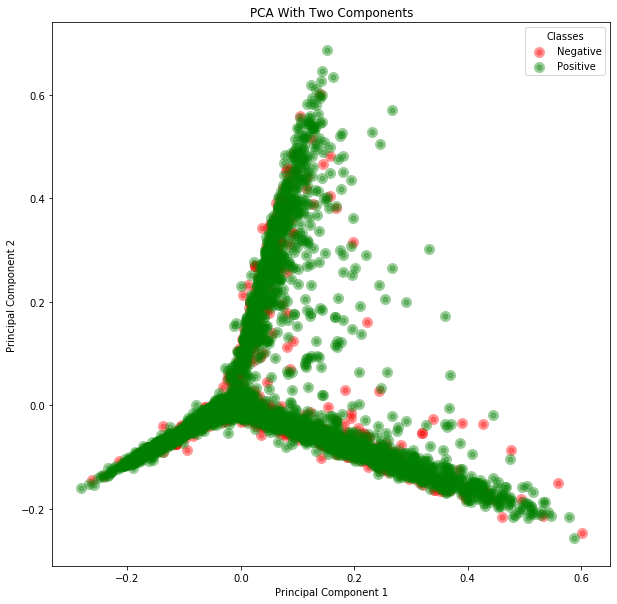

In [83]:
pca = PCA(n_components=2).fit_transform(tfidf_train_dense)

# Setting up plot
fig, ax = plt.subplots(figsize=(10, 10))

first_component = pca[:, 0]
second_component =  pca[:, 1]

# Plotting scatterplot with positive and negative examples
# Negative = 0
ax.scatter(
    first_component[y_train_small == 0], second_component[y_train_small == 0], 
    linewidths=5, alpha=.4, marker='o', c='r', label='Negative'
)

# Positive = 1
ax.scatter(
    first_component[y_train_small == 1], second_component[y_train_small == 1], 
    linewidths=5, alpha=.4, marker='o', c='g', label='Positive'
)

plt.legend(title='Classes')

ax.set_title("PCA With Two Components")
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

plt.show()

In [78]:
tfidf_train_smote_small, y_train_smote_small = resample(
    x_train_smote, y_train_smote, 
    replace=False, 
    n_samples=10000, 
    random_state=1,
    stratify=y_train_smote
)
tfidf_train_smote_dense = tfidf_train_smote_small.todense()

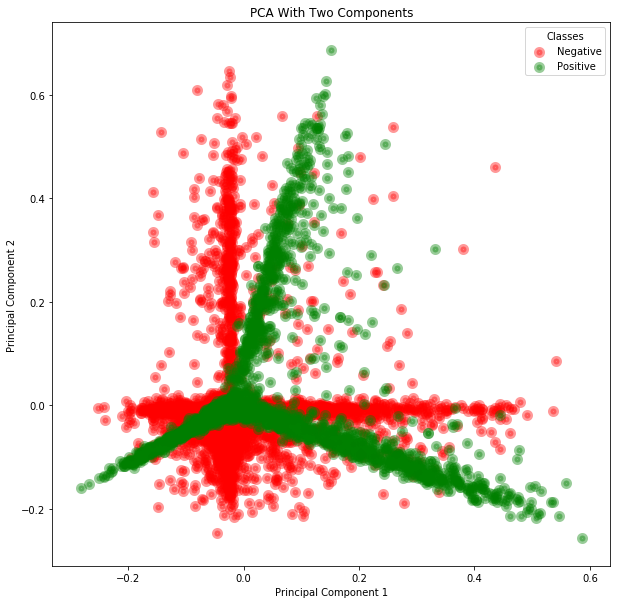

In [82]:
pca_smote = PCA(n_components=2).fit_transform(tfidf_train_smote_dense)

# Setting up plot
fig, ax = plt.subplots(figsize=(10, 10))

first_component_smote = pca_smote[:, 0]
second_component_smote =  pca_smote[:, 1]

# Plotting scatterplot with positive and negative examples
# Negative = 0
ax.scatter(
    first_component_smote[y_train_smote_small == 0], second_component[y_train_smote_small == 0], 
    linewidths=5, alpha=.4, marker='o', c='r', label='Negative'
)

# Positive = 1
ax.scatter(
    first_component[y_train_smote_small == 1], second_component[y_train_smote_small == 1], 
    linewidths=5, alpha=.4, marker='o', c='g', label='Positive'
)

plt.legend(title='Classes')

ax.set_title("PCA With Two Components")
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

plt.show()